In [1]:
#UNADJUSTED, ADJUSTED, AND ALL RATIOS MUST BE PLOTTED IN ORDER

import uproot
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from IPython.display import Image, display
from IPython.display import HTML

np.seterr(divide='ignore', invalid='ignore') # Ignore division errors >:)

class Type:
    def __init__(self, name):
        self.name = name
        self.sameSignFile = uproot.open('highHcal_'+str(name)+'_tagAligned (2).root')
        self.sameSignEvents = self.sameSignFile['demo']['allEvents']['sigVariables']
        self.branches = self.sameSignEvents.arrays()
        self.EventWeight = self.branches['EventWeight']
        self.eta = self.branches['eta']
        self.phi = self.branches['phi']
        
        self.DR_S = []
        self.DPhi_S = []
        self.DEta_S = []

        for i in range (4):
            self.DR_S.append(self.branches['dtDRbyStation_' + str(i)])
            self.DPhi_S.append(self.branches['dtDPhibyStation_' + str(i)])
            self.DEta_S.append(self.branches['dtDEtabyStation_' + str(i)])

Data = Type('data')
MC = Type('mc')

print('init uproot')

#Data.sameSignFile.keys()
#Data.sameSignEvents
#Data.sameSignEvents.keys()
#Data.branches['pt']

#Coord refers to DR, DPhi, or DEta
class Coord:
    def __init__(self,name,x1,x2,bins):
        self.name = name
        self.x1 = x1
        self.x2 = x2
        self.bins = np.linspace(x1, x2, bins+1)  # creates an array of bin edges
        self.bin_width = (x2 - x1) / bins

DR = Coord('DR',0,0.35,100)   # set delta coord edges/bin
DPhi = Coord('DPhi',0,0.35,100)   # set delta coord edges/bin
DEta = Coord('DEta',0,0.35,100)   # set delta coord edges/bin

# Initialize class to help calculate normalized histograms for any data set
class NormalizedHist:
    def __init__(self, data, view_bins, bin_width):
        self.data = data[0]
        self.view_bins = view_bins
        self.bin_width = bin_width
        self.norm_factor = 1 / (np.sum(self.data) * self.bin_width)      # normalization factor
        self.temp = (data[1] + self.bin_width / 2)                       # offset bin edge values by + 1/2 bin
        self.bin_centers = self.temp[:-1]                                # cut last value to give bin center
        self.freq = self.data * self.norm_factor                         # normalized frequency
        self.err = (self.data ** 0.5) * self.norm_factor                 # normalized vertical error bar

print('init classes')

#---------------------------------------------------------------------------------------------------------------------------------------

# Use pandas to make an array of values ordered by event ID
features=[]
for i in range(4):
    features.append('dtDRbyStation_'+str(i))
    features.append('dtDPhibyStation_'+str(i))
    features.append('dtDEtabyStation_'+str(i))
features.append('EventWeight')
    
mcEvents = MC.sameSignEvents.arrays(features, library='pd')
dataEvents = Data.sameSignEvents.arrays(features, library='pd')

Coordinates = [DR, DPhi, DEta]
for coord in Coordinates:
    bin_indices = np.zeros_like(MC.DR_S[i].to_numpy())         # Array for storing bin indices
    for j, deltaCoord in enumerate(MC.DR_S[i]):                    # [(0, delta_R), (1, delta_R) ...] <--- list(enumerate(")) should give this
        bin_indices[j] = np.digitize(deltaCoord, coord.bins) - 1      # returns bin index for each delta coord
        mcEvents[str(coord.name)+'_Bin_Station_'+str(i)] = bin_indices          # Add new column with bin indices                                            
#print(mcEvents[:5])

ratio_freq = []
ratio_Station = []
ratio_Iter = []

print('init dataframe')

#---------------------------------------------------------------------------------------------------------------------------------------

# Method for plotting histograms
def generate_hist(condition, coord, x1, x2, i, j):

    if coord.name == 'DR':
        station_Data = Data.DR_S[i]
        station_MC = MC.DR_S[i]
    elif coord.name == 'DPhi':
        station_Data = Data.DPhi_S[i]
        station_MC = MC.DPhi_S[i]
    elif coord.name == 'DEta':
        station_Data = Data.DEta_S[i]
        station_MC = MC.DEta_S[i]

    if condition == 'unadjusted':
        weights = MC.EventWeight
    elif condition == 'adjusted':
        weights = MC.EventWeight*mcEvents['Ratio_Station_'+str(j)].to_list()
    elif condition == 'all ratios':
        if i == 0:
            mcEvents['All_Ratios'] = mcEvents['Ratio_Station_0']*mcEvents['Ratio_Station_1']*mcEvents['Ratio_Station_2']*mcEvents['Ratio_Station_3'] # by event
        weights = MC.EventWeight*mcEvents['All_Ratios'].to_list()
    elif condition == 'iterative':
        if j == 0 and i == 0:
            mcEvents['Ratio_Iter_0'] = mcEvents['Ratio_Station_0'].to_list()
        weights = MC.EventWeight
        for k in range(j+1):
            weights = weights*mcEvents['Ratio_Iter_'+str(k)].to_list()

    # Create numpy histogram data for Data & MC so ratio can be calculated by initializing each as NormalizedHist Class
    data_hist = NormalizedHist(np.histogram(station_Data, bins=coord.bins, range=(coord.x1, coord.x2), density=None), len(coord.bins), coord.bin_width)
    mc_hist = NormalizedHist(np.histogram(station_MC, bins=coord.bins, range=(coord.x1, coord.x2), density=None, weights=weights), len(coord.bins), coord.bin_width)
        
    if condition == 'adjusted' or condition == 'all ratios':
        mc_hist_unadj = NormalizedHist(np.histogram(station_MC, bins=coord.bins, range=(coord.x1, coord.x2), density=None, weights=MC.EventWeight), len(coord.bins), coord.bin_width)
        adj_factor = np.divide(mc_hist.freq, mc_hist_unadj.freq + 1e-10)
    elif condition == 'iterative':
        if j == 0:
            mc_hist_unadj = NormalizedHist(np.histogram(station_MC, bins=coord.bins, range=(coord.x1, coord.x2), density=None, weights=MC.EventWeight), len(coord.bins), coord.bin_width)
        else:
            mc_hist_unadj = NormalizedHist(np.histogram(station_MC, bins=coord.bins, range=(coord.x1, coord.x2), density=None, weights=MC.EventWeight*mcEvents['Ratio_Iter_'+str(j-1)].to_list()), len(coord.bins), coord.bin_width)
        adj_factor = np.divide(mc_hist.freq, mc_hist_unadj.freq + 1e-10)
    
    ratio_freq = np.divide(data_hist.freq, mc_hist.freq)
    ratio_freq = [1 if math.isinf(x) else x for x in ratio_freq] # goodify the infinities
    ratio_err = ratio_freq * np.sqrt((data_hist.err / (data_hist.freq + 1e-10))**2 + (mc_hist.err / (mc_hist.freq + 1e-10))**2) 
    # calculate ratio error -> propagation of uncertainty


    if condition == 'unadjusted':
        # Loop over events, assign bin ratio to each event
        ratio_Station.append(np.zeros_like(station_MC.to_numpy()))             # create empty array similar to DCoord for station[j]
        for k, deltaCoord in enumerate(station_MC):                            # [(0, delta_R), (1, delta_R) ...] <--- list(enumerate(")) should give this
            bin_index = np.digitize(deltaCoord, coord.bins) - 1                # returns bin index for each delta coord
            if bin_index >= len(ratio_freq):                                   # check if index is out of bound
                bin_index = len(ratio_freq) - 1                                # assign the last valid index
            ratio_Station[i][k] = ratio_freq[bin_index]                        # find item k in array and change it to the ratio_freq of that bin index
    
        assert len(mcEvents) == len(ratio_Station[i])            # make sure length matches
        mcEvents['Ratio_Station_'+str(i)] = ratio_Station[i]     # add new column

    if condition == 'iterative' and i-1 == j:                                  # take ratio freq between Station_i Data and MC adjusted by ratio from station (i-1) adjusted MC for 
        ratio_iter = ratio_freq                                                # recall that ratio_freq has already been iterated in this case
        # Loop over events, assign bin ratio to each event
        ratio_Iter.append(np.zeros_like(station_MC.to_numpy()))                # create empty array similar to DCoord for station[j]
        for k, deltaCoord in enumerate(station_MC):                            # [(0, delta_R), (1, delta_R) ...] <--- list(enumerate(")) should give this
            bin_index = np.digitize(deltaCoord, coord.bins) - 1                # returns bin index for each delta coord
            if bin_index >= len(ratio_iter):                                   # check if index is out of bound
                bin_index = len(ratio_iter) - 1                                # assign the last valid index
            ratio_Iter[j][k] = ratio_iter[bin_index]                           # find item k in array and change it to the ratio_iter of that bin index
    
        assert len(mcEvents) == len(ratio_Iter[j])            # make sure length matches
        mcEvents['Ratio_Iter_'+str(i)] = ratio_Iter[j]        # add new column

    #PLOT -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -

    # Adjusting axs[0].step from bin edge to bin center results in loss of first bar because it is shifted 1/2 bin width; this adds that point back at 0
    step_bc = mc_hist.bin_centers+coord.bin_width/2
    step_f = mc_hist.freq
    step_bc.to_numpy
    step_f.to_numpy
    step_bin_centers = np.insert(step_bc, 0, 0.0)
    step_freq = np.insert(step_f, 0, mc_hist.freq[0])

    # Set up histogram, use bars for MC
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [3, 1]}, figsize=(7, 5))
    axs[0].step(step_bin_centers, step_freq, label='Monte Carlo')
    if condition == 'unadjusted':
        axs[0].set_title('Distance to Station '+str(i))
    elif condition == 'adjusted':
        axs[0].set_title('Distance to Station '+str(i)+' Weighted by Station '+str(j)+' Ratios')
    elif condition == 'all ratios':
        axs[0].set_title('Distance to Station '+str(i)+' Weighted by All Ratios')
    elif condition == 'iterative':
        axs[0].set_title('Distance to Station '+str(i)+' Weighted by Iterative Ratios '+str(j))
    axs[0].set_ylabel('Event Frequency (Normalized)')
    axs[0].set_yscale('log')
    
    # Scatter data by attribute
    axs[0].scatter(data_hist.bin_centers, data_hist.freq, s=10, color='darkorange', label='Data')
    axs[0].errorbar(data_hist.bin_centers, data_hist.freq, xerr=coord.bin_width/2, yerr=mc_hist.err, fmt='+')
    axs[0].set_xlim(x1, x2)
    axs[0].legend()

    # Scatter ratio plot
    axs[1].scatter(data_hist.bin_centers, ratio_freq, s=10)
    axs[1].errorbar(data_hist.bin_centers, ratio_freq, yerr=ratio_err, fmt='+')
    axs[1].set_ylim(0,2)
    axs[1].set_ylabel('Ratio')
    axs[1].set_xlabel('$\Delta$'+coord.name+' to Station '+str(i))

    if condition == 'unadjusted':
        plt.savefig(coord.name+' Distance to Station '+str(i)+'.jpg')
        
    elif condition == 'adjusted':
        plt.savefig(coord.name+' Distance to Station '+str(i)+' Weighted by Station '+str(j)+' Ratios.jpg')
        plt.close() # prevents figure from being displayed when code cell is executed
        plt.scatter(data_hist.bin_centers, adj_factor)
        plt.xlabel('$\Delta$'+coord.name+' to Station '+str(j))
        plt.ylabel('Adjustment Factor')
        plt.title('Net Adjustment by Station '+str(j)+' Ratios for Station '+str(i))
        plt.savefig(coord.name+' Net Adjustment by Station '+str(j)+' Ratios for Station '+str(i)+'.jpg')
        
    elif condition == 'all ratios':
        plt.savefig(coord.name+' Distance to Station '+str(i)+' Weighted by All Ratios.jpg')
        plt.close()  # prevents figure from being displayed when code cell is executed
        plt.scatter(data_hist.bin_centers, adj_factor)
        plt.xlabel('$\Delta$'+coord.name+' to Station '+str(j))
        plt.ylabel('Adjustment Factor')
        plt.title('Net Adjustment by All Ratios for Station '+str(i))
        plt.savefig(coord.name+' Net Adjustment by All Ratios for Station '+str(i)+'.jpg')
        
    elif condition == 'iterative':
        plt.savefig(coord.name+' Distance to Station '+str(i)+' Weighted by Iterative Ratios '+str(j)+'.jpg')
        plt.close()  # prevents figure from being displayed when code cell is executed
        plt.scatter(data_hist.bin_centers, adj_factor)
        plt.xlabel('$\Delta$'+coord.name+' to Station '+str(j))
        plt.ylabel('Adjustment Factor')
        plt.title('Net Adjustment by Iterative Ratios '+str(j)+' for Station '+str(i))
        plt.savefig(coord.name+' Net Adjustment by Iterative Ratios '+str(j)+' for Station '+str(i)+'.jpg')

    plt.close()
    return mc_hist, data_hist

print('init generate_hist')
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    
def compile_hist(coord, x1, x2):
    
    for i in range (4):
        generate_hist(condition='unadjusted', coord=coord, x1=x1, x2=x2, i=i, j=1)
    print('compiled unadjusted')

    for j in range (4):                          #j iterates through station weights
        for i in range (4):                      #i iterates through stations
            generate_hist(condition='adjusted', coord=coord, x1=x1, x2=x2, i=i, j=j)
    print('compiled adjusted')
        
    for i in range (4):                    
        generate_hist(condition='all ratios', coord=coord, x1=x1, x2=x2, i=i, j=1)
    print('compiled all ratios')

    for j in range (4):                          #j iterates through station weights
        for i in range (4):                      #i iterates through stations
            generate_hist(condition='iterative', coord=coord, x1=x1, x2=x2, i=i, j=j)
    print('compiled iterative')

print('init compile_hist')

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

def plot_hist(coord):

    for j in range(4):
        for k in range(2):
            print("\n") 
        print('                            ------------------------------------------------------------------------------- All Stations Weighted by Station '+str(j)+' Ratios: -------------------------------------------------------------------------------')
        for k in range(2):
            print("\n")
        for i in range(4):
            display(HTML("<table><tr><td><img src='"+coord.name+" Distance to Station "+str(i)+".jpg'></td><td><img src='"+coord.name+" Net Adjustment by Station "+str(j)+" Ratios for Station "+str(i)+".jpg'></td><td><img src='"+coord.name+" Distance to Station "+str(i)+" Weighted by Station "+str(j)+" Ratios.jpg'></td></tr></table>"))
    
    for k in range(2):
        print("\n") 
    print('                            ------------------------------------------------------------------------------- All Stations Weighted by All Ratios: -------------------------------------------------------------------------------')
    for k in range(2):
        print("\n")
    for i in range(4):
        display(HTML("<table><tr><td><img src='"+coord.name+" Distance to Station "+str(i)+".jpg'></td><td><img src='"+coord.name+" Net Adjustment by All Ratios for Station "+str(i)+".jpg'></td><td><img src='"+coord.name+" Distance to Station "+str(i)+" Weighted by All Ratios.jpg'></td></tr></table>"))

    for j in range(4):
        for k in range(2):
            print("\n") 
        print('                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios '+str(j)+': -------------------------------------------------------------------------------')
        for k in range(2):
            print("\n")
        for i in range(4):
            display(HTML("<table><tr><td><img src='"+coord.name+" Distance to Station "+str(i)+".jpg'></td><td><img src='"+coord.name+" Net Adjustment by Iterative Ratios "+str(j)+" for Station "+str(i)+".jpg'></td><td><img src='"+coord.name+" Distance to Station "+str(i)+" Weighted by Iterative Ratios "+str(j)+".jpg'></td></tr></table>"))

print('init plot_hist')

print('initialized')

init uproot
init classes
init dataframe
init generate_hist
init compile_hist
init plot_hist
initialized


In [2]:
compile_hist(DR, 0, 0.35)
plot_hist(DR)

compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative




                            ------------------------------------------------------------------------------- All Stations Weighted by Station 0 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 1 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 2 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 3 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by All Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 0: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 1: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 2: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 3: -------------------------------------------------------------------------------






,,


,,


,,


,,


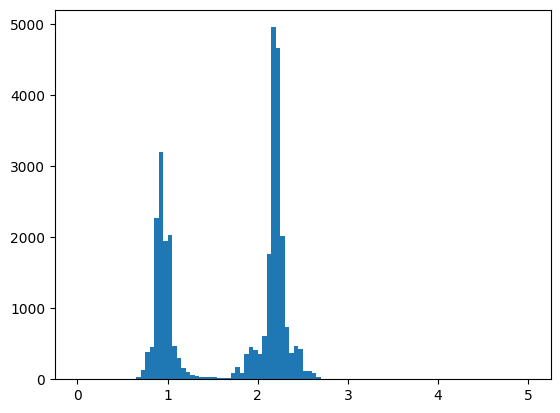

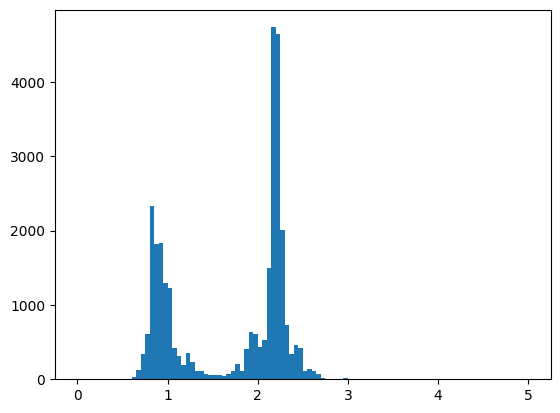

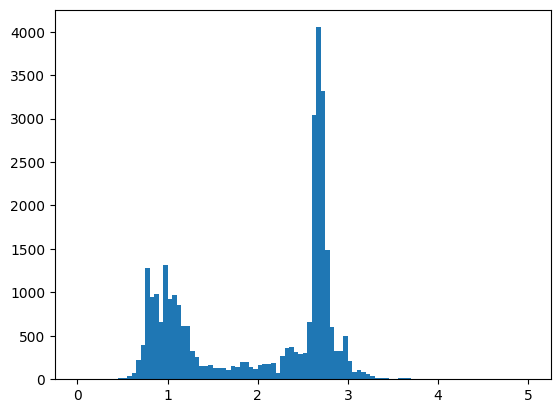

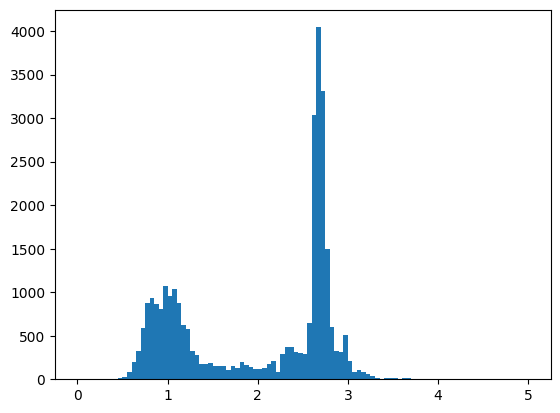

In [3]:
weights = MC.EventWeight
for i in range(4):
    weights = weights*mcEvents['Ratio_Iter_'+str(i)].to_list()
    plt.hist(weights, bins=100, range=(0, 5), density=None)
    plt.show()

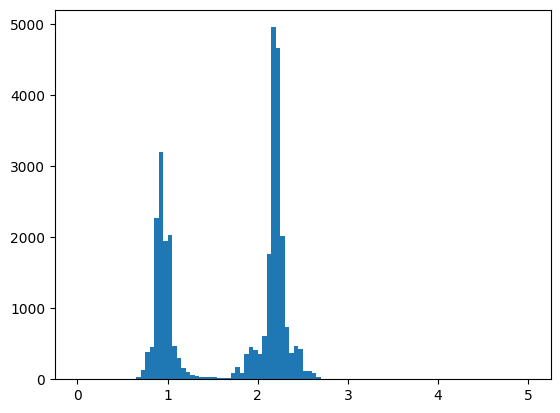

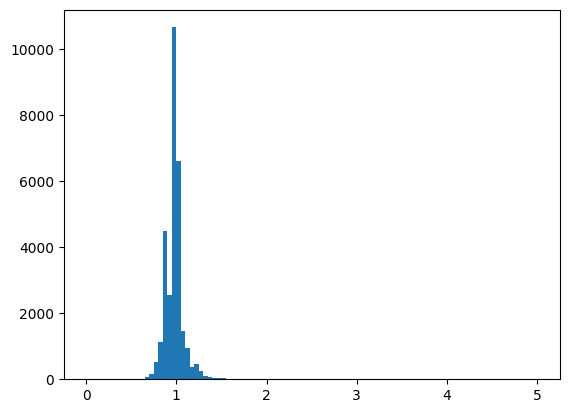

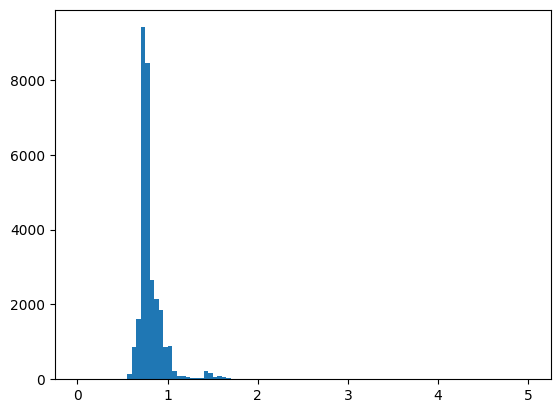

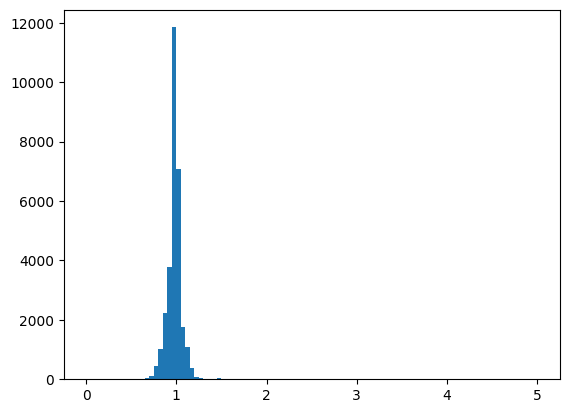

In [4]:
for i in range(4):
    weights = MC.EventWeight*mcEvents['Ratio_Station_'+str(i)].to_list()
    plt.hist(weights, bins=100, range=(0, 5), density=None)
    plt.show()

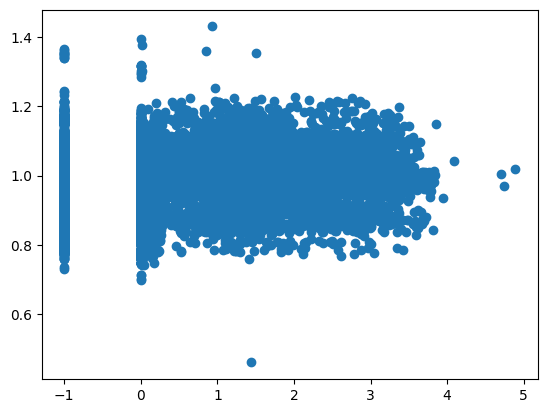

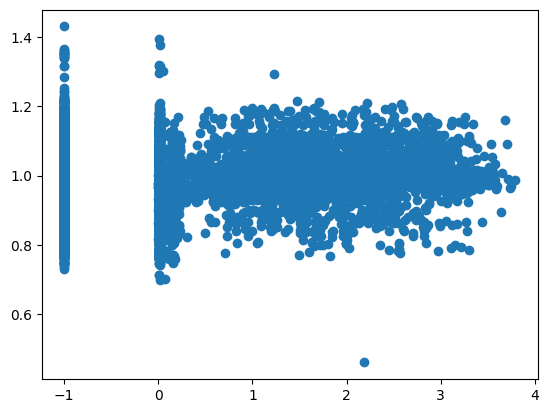

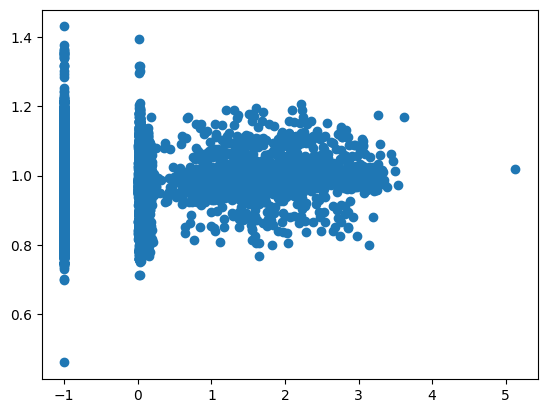

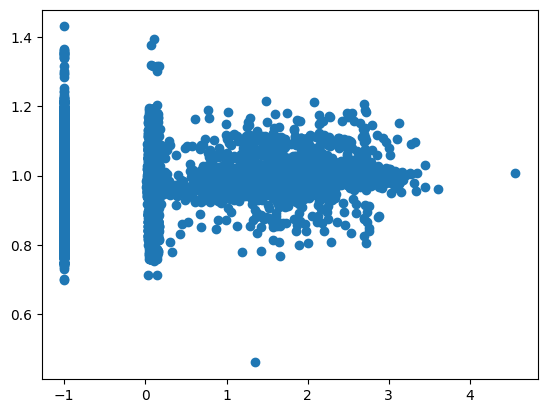

In [5]:
for i in range(4):
    plt.scatter(mcEvents['dtDRbyStation_'+str(i)].to_list(), mcEvents['EventWeight'].to_list())
    plt.show()

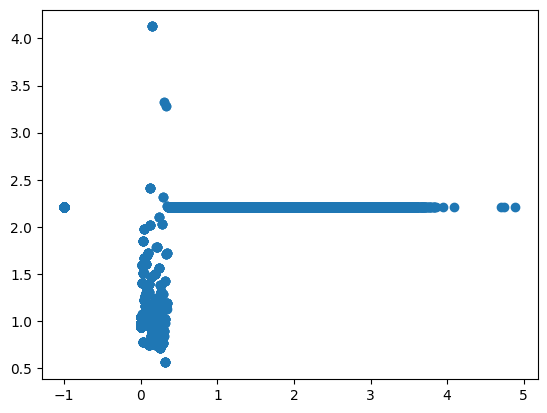

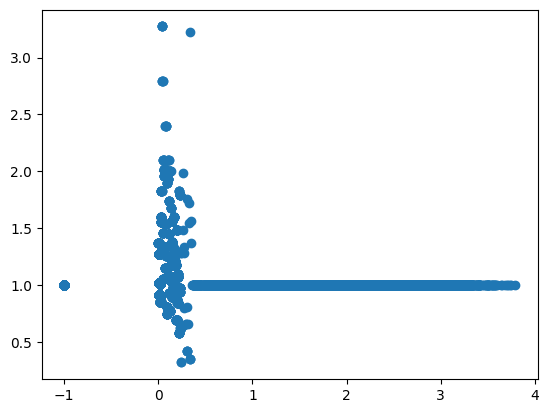

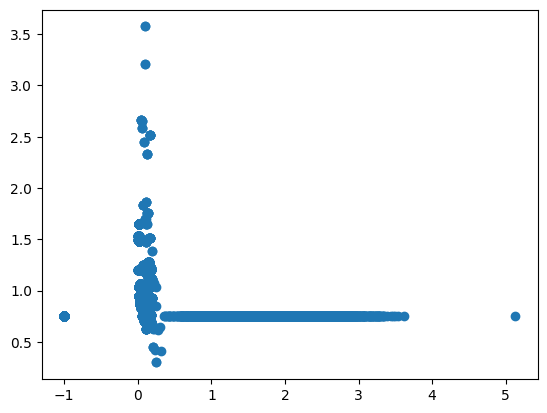

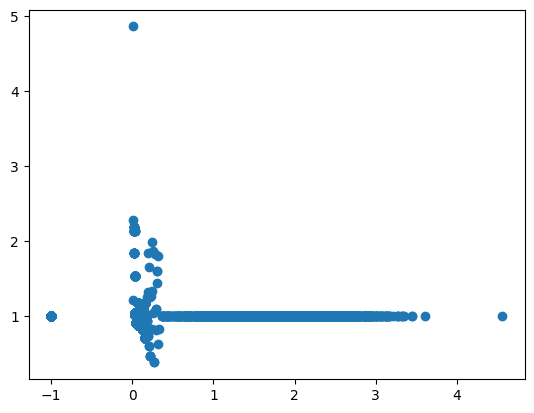

In [6]:
for i in range(4):
    plt.scatter(mcEvents['dtDRbyStation_'+str(i)].to_list(), mcEvents['Ratio_Station_'+str(i)].to_list())
    plt.show()

In [7]:
#compile_hist('DPhi', 0, 0.35)
#plot_hist('DPhi')

In [8]:
#compile_hist('DEta', 0, 0.35)
#plot_hist('DEta')